<center><font size="+4" face="Computer Modern">AdaBoost from scratch implementation</font></center>

<center><font size="+2" face="Computer Modern">Project for the Machine Learning course of Data Science and Economics</font></center>

![title](img/tesiSCIENZE_POLITICHE.jpg)

<center><font size="+2" face="Computer Modern">Marco Cazzola (ID: 964573)</font></center> 

<center><font size="+2" face="Computer Modern">A.Y. 2021/22</font></center>

<center><i>I declare that this material, which I now submit for assessment, is entirely my own work and has not been taken from the work of others, save and to the extent that such work has been cited and acknowledged within the text of my work. I understand that plagiarism, collusion, and copying are grave and serious offences in the university and accept the penalties that would be imposed should I engage in plagiarism, collusion or copying. This assignment, or any part of it, has not been previously submitted by me or any other person for assessment on this or any other course of study.</i></center>

# Abstract

In this paper, we are going to implement from scratch the AdaBoost algorithm, using just basic libraries like `numpy` and `pandas`. We then are going to apply the algorithm to the [Cover-Type dataset](https://www.kaggle.com/c/forest-cover-type-prediction/data?select=train.csv) and build seven different binary classifiers, one for each of the response's classes. We then combine these seven binary classifiers to obtain a single multiclass classifier, and study its cross-validated performance according to the zero-one loss to select a proper number of AdaBoost rounds. Finally, after splitting the data into a training and test set, we take a closer look to the algorithm's output, highlighting for example the classes for which the classification worked best and the most important variables in terms of predictive power. 

# Index

1. [Theoretical background](#Theoretical-background)
  1. [AdaBoost](#AdaBoost)
  2. [Model evaluation](#Model-evaluation)
2. [Implementation](#Implementation)
  1. [Base learner](#Base-learner)
  2. [Learning algorithm](#Learning-algorithm)
  3. [Cross-validation](#Cross-validation)
3. [Exploratory data analysis](#Exploratory-data-analysis)
  1. [Target variable](#Target-variable)
  2. [Quantitative predictors](#Quantitative-predictors)
  3. [Qualitative predictors](#Qualitative-predictors)
4. [Cross-validated multiclass classification](#Cross-validated-multiclass-classification)
5. [Training-test procedure](#Training-test-procedure)
  1. [Variables importance](#Variables-importance)
6. [Conclusion](#Conclusion)
7. [Appendix](#Appendix) 

# Theoretical background

In this section, we will present a theoretical overview of the AdaBoost algorithm. We will not go into details of the mathematical foundation of the algorithm, since this would be beyond the scope of the paper. The aim of this section is just to give some intuition about the algorithm's functioning, so that the functions that we will implement later will be more readable and understandable. \
After presenting the learning algorithm, we will briefly discuss how to properly evaluate its performance through K-fold (external) cross validation. 

## AdaBoost

Similarly to bagging and random forest, AdaBoost is an ensemble method, meaning that it combines an ensemble of simple classifiers to deliver its final prediction. However, while bagging and random forest use an ensemble of equally-weighted predictors grown on different (bootstrapped) training sets, in AdaBoost each simple predictor is trained on the whole training set and it is assigned a weight based on its training performance. Moreover, while in bagging and random forest different simple classifiers are expected to make independent predictions, in AdaBoost each weak learner retains some information from its predecessors. More precisely, suppose we are in a binary classification setting (i.e., $\mathcal{Y} = \{-1, +1\}$), we have $m$ training examples $\{(\textbf{x}_1, y_1), ..., (\textbf{x}_m, y_m)\}$ and a sequence of *base classifiers* $h_1, ..., h_T$ generated by some learninng algorithm A. Then, AdaBoost outputs a classifier of the form: 

$$
sgn(f(\textbf{x})) = sgn\left(\sum_{i=1}^{T} w_ih_i(\textbf{x})\right)
$$

Where $sgn(\cdot)$ is the *sign function* defined as: 

$$
sgn(\alpha)=\begin{cases} +1 \quad if \quad \alpha \geq 0 \\ -1 \quad if \quad \alpha < 0 \end{cases}
$$

And $\textbf{w}=(w_1, ..., w_T)$ is a vector of real coefficients. 

A typical choice for the base classifiers is the one of *decision stumps*, that are classifiers of the form $h_{j, \theta}:\mathbb{R}^d \rightarrow \{-1, +1\}$ defined as $h_{j, \theta}(\textbf{x}) = \pm sgn(x_j - \theta)$. Basically, a decision stump takes as input a threshold $\theta$ and a feature $x_j$, splitting the observations into two groups: one with $x_j \geq \theta$ and the other one with $x_j < \theta$. Then, it predicts either $+1$ for the first group and $-1$ for the second one or vice versa, according to the solution which yields the minimum error. In fact, a decision stump can have at most a 50% misclassification rate in a binary classification setting: if error $\varepsilon > 0.5$, it is sufficient to flip the predictions' sign to obtain an error equal to $1-\varepsilon < 0.5$. 

In the chapter's introduction, we said that each base classifier output by AdaBoost retains some information from its predecessors. Indeed, in the case of AdaBoost, the objective of the decision stump is to minimize a *weighted* version of the training error, defined according to a probability distribution $\mathbb{P}_i$ over the training examples. As we will see, this probability distribution depends by the mistakes made by the previous base classifiers, and in that sense we can say that each stump learns also from its predecessors. Introducing $L_i(t)=h_i(\textbf{x}_t)y_t$, each classifier $h_i$ tries to minimize the quantity: 

$$
\varepsilon_i = \mathbb{P}_i(L_i=-1)=\sum_{t=1}^{m} \mathbb{I}\{L_i(t)=-1\}\mathbb{P}_i(t)
$$


Where $\mathbb{I}\{A\}$ is the indicator function of event $A$, defined as: 

$$
\mathbb{I}(A)=\begin{cases} 1 \quad if \quad A\ is\ true \\ 0 \quad otherwise \end{cases}
$$

Notice that, since we are in a binary classification setting, $L_i(t) \in \{-1,+1\} \ \forall \ t \in \{1, ..., m\}$. More precisely, when $L_i(t)=-1$, it means the predictions and the actual label have opposite signs, or, in simpler words, the prediction was wrong. Keeping that in mind, it is clear that the above expression is a weighted version of the training error, traditionally computed with equal weights for all the observations (i.e., with $\mathbb{P}_i$ being a uniform distribution). 

The AdaBoost algorithm consists in feeding T times the base algorithm A with the training set weighted each time by a different probability distribution $\mathbb{P}_i$, where $i=1, ..., T$. The update rule for such probability distribution is the following:

$$
\mathbb{P}_{i+1}(t) = \frac{\mathbb{P}_i(t) \cdot e^{-w_iL_i(t)}}{\sum_{s=1}^{m} e^{-w_iL_i(s)}\cdot \mathbb{P}_i(s)} \qquad starting \ from \qquad \mathbb{P}_1(t)=\frac{1}{m} \ \forall \ t = 1, ..., m
$$

Basically, we start from a uniform distribution where all the observations have exactly the same weight, and then we update the probabilities according to the rule displayed on the left. \
Notice how this rule ensures that the probability is always greater than zero and it actually constitutes a probability distribution, because thanks to the normalization factor in the denominator we are sure the probabilities sum up to one. We can treat this quantity in the denominator as a constant and focus on the numerator to understand the rationale behind this rule. \
We have already said that $L_i(t)=-1$ means that predictor $h_i$ misclassified the training example $(\textbf{x}_t, y_t)$. In the next paragraph we will focus on the real weights $w_i$, but for the moment be aware that they are always $\geq 0$. Keeping in mind these two aspects, and ignoring for the moment the possibility $w_i=0$, we have that the quantity  $e^{-w_iL_i(t)}$ is greater than one if and only if $L_i(t)=-1$, or, in simpler words, if $h_i$ misclassifies the t-th training example. In the other case, when $L_i(t)=1$, the power of $e$ will instead be less than one. \
In practice, this means that at each iteration, the weight of the t-th training example:

- is increased if $(\textbf{x}_t, y_t)$ is misclassified by the current base classifier
- is decreased if $(\textbf{x}_t, y_t)$ is correctly classified by the current base classifier

In this way, each base classifier focuses its attention towards the examples that were misclassified by its predecessors, so that the final prediction, which will consider the entire sequence of base classifiers, can deliver a significantly better performance than the one we would obtain considering just a single base classifier alone. 

It is now time to consider the last aspect of the AdaBoost algorithm, that is the weights assigned to each base classifier. The formula to compute these weights is the following: 

$$
w_i = \frac{1}{2} ln \left(\frac{1-\varepsilon_i}{\varepsilon_i}\right)
$$

The rationale behind this formula is simple, and can be easily illustrated by plotting $w_i$ as a function of $\varepsilon_i$.

![weight_func](img/weight_func.png)

First of all, recall that previously we said the weights are always positive: indeed, from the graph we see that $0 \leq \varepsilon \leq 0.5$ implies $w \geq 0$. Since the error $\varepsilon > 0.5$ can always be made $< 0.5$ by flipping the predictions' signs, we have that $\varepsilon_i$ always varies between $0$ and $0.5$, and therefore weights always vary between $0$ and $+\infty$. \
More precisely, as the error increases towards $0.5$, the weight goes to zero, while as the error approaches zero, the weight goes to infinity, so that best-performing classifiers (with low training error) are given the largest weights, while worst-performing stumps (with a training error close to $0.5$) are given smaller weights. Basically, we have two special cases, given by: 

$$
\lim_{\varepsilon_i\to0^+} ln \left(\frac{1-\varepsilon_i}{\varepsilon_i}\right) = +\infty 
\qquad and \qquad
\lim_{\varepsilon_i\to0.5^-} ln \left(\frac{1-\varepsilon_i}{\varepsilon_i}\right) = 0 
$$

If any of those two special cases were to happen, we would deal with it in the following way: 

- If $\varepsilon_i=0$, it means we have found a perfect predictor (at least on the training set) and we can avoid using boosting altogether: we will make predictions using only that specific stump $h_i$ for which $\varepsilon_i=0$;
- If $\varepsilon_i=0.5$, it means the algorithm cannot learn anything more, because when $\varepsilon_i=0.5$ the update rule of the probability distribution will not make any update, since it would simply multiply the current probability by $e^0=1$. If we were to reach an error of $0.5$, we would therefore stop the learning procedure and consider just the stumps built until that point. 

So far, we have only talked about binary classification, but actually the learning problem we are going to analyse in this paper is a multiclass classification problem, since we will have to deal with seven different classes. Our approach to the problem will consist in training seven binary classifiers of the form $h_s(\textbf{x})=sgn(g_s(\textbf{x}))$ for $s=1, 2, ..., 7$, one for each of the classes. We will then make predictions using: 

$$
\hat{y}=\underset{s=1,...,7}{argmax}\{g_s(\textbf{x})\}
$$

## Model evaluation

Now that we have defined how the learning algorithm works, we should also discuss about the method we will use to evaluate its performance. \
A naïve approach may be to divide the data into a training and a test set, train the learning algorithm on the training set and test it on the test set. Since the observations in the test set are not used in the learning phase, we could assume this is a good way to estimate the goodness of a learning algorithm. However, this is not true. If we were to repeat this procedure with different training and test set splits, we could observe a very different value each time. In fact, what we would like to estimate is the *expected value* of the statistical risk of the learning algorithm we are using, $\mathbb{E}\left[\ell_D(A)\right]$, where the expectation is to be understood with respect to the random draw of the training set. Intuitively, $\mathbb{E}\left[\ell_D(A)\right]$ can be seen as a measure of the performance of the learning algorithm on a typical training set of fixed size. Using the training-test approach to estimate this quantity would be just like estimating the mean of a population with a single observation: a clearly unreliable method. 

What we need to do is to extract several test error estimates from the same data set. *K-fold cross-validation* is the technique we can use to reach this goal. This approach involves randomly dividing the set of observations into $K$ folds of approximately equal size. The first fold is treated as a test set, and the method is fit on the remaining $K-1$ folds. Once the learning procedure has ended, the loss is computed on the test fold. This procedure is repeated $K$ times, each time using a different fold for test purposes. The process results in $K$ estimates of the test error, which are then averaged to compute the estimate of the expected statistical risk of the given learning algorithm $A$: 

$$
\hat{\ell}_S^{CV}(A)=\frac{1}{K} \sum_{k=1}^{K} \hat{\ell}_{D_k}(h_k)
$$

Where $\hat{\ell}_{D_k}(h_k)$ is the test error of predictor $h_k$, obtained when using the k-th fold for testing purposes. 

A typical choice for $K$ is 3, 5, or even 10. Clearly, as we increase $K$, the procedure becomes more and more computationally intensive. In this paper, we will therefore use $K=5$. 

Go to [Index](#Index)

# Implementation

As discussed in the abstract, this paper is about implementing from scratch AdaBoost algorithm. However, some basic libraries are needed. More precisely, we will rely on `pandas` for the data structure and `numpy` for the arithmetic operations. We will also use `matplotlib` and `seaborn` for data visualization purposes, and finally also `sklearn` library, but only to perform the training-test split and to build a confusion matrix. Let's therefore import all these libraries and modules before moving to customized functions. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#Data visualization settings
sns.set(rc={"figure.dpi":300, "savefig.dpi":300})
sns.set_context('notebook')
sns.set_style("ticks")

## Base learner

We will now implement the logic to build the base classifiers of AdaBoost, decision stumps. For the sake of simpler explanation, we decided to define two different stump functions: 

* `stump` is the function we will use in the training phase. This function takes as argument the entire features' dataframe `X`, the binary labels vector `y` and the training examples probability distribution `prob`. We then have the two characteristic parameters of a decision stump: the feature `feat` and the threshold `theta`. The latter is set to $0.5$ so that we can easily deal with categorical variables whose value is either $0$ or $1$. The function returns three elements: a vector `L` ($L_i(t)$ from the [Theoretical background](#Theoretical-background) section); the boolean `greater_is_positive`, telling us which observations should be labelled positively or negatively; the weighted error `w_err`. 
* `std_stump` is instead the function we will use in the prediction phase. In fact, this function has the same arguments (with the same meaning) of `stump`, but, differently from it, it has no probability distribution to consider, and takes as argument `greater_is_positive`, the configuration parameter output by the previous function. `std_stump` returns two elements: prediction `preds` and error rate `err_rate`. 

In [2]:
def stump(X, y, prob, feat, theta=0.5): 
    
    # Predict +1 if X[feat] >= theta, -1 otherwise
    greater_is_positive = True
    
    preds = np.ones(len(y))
    preds[X[feat] < theta] = -1
    
    # Computing L_i(t)
    L = preds * y
    
    # Computing the *weighted* error
    w_err = sum(prob[y != preds])
    
    # Flip the sign if error > 0.5
    if w_err > 0.5: 
        w_err = 1 - w_err
        L *= -1
        greater_is_positive = False
        
    return(L, greater_is_positive, w_err)

In [3]:
def std_stump(X, y, feat, greater_is_positive, theta=0.5): 
    
    preds = np.ones(len(y))
    
    if greater_is_positive:
        preds[X[feat] < theta] = -1
        err_rate = sum(y != preds)/len(y)
        
    else: 
        preds[X[feat] >= theta] = -1
        err_rate = sum(y != preds)/len(y)
        
    return(preds, err_rate)

We now need a function to identify which are the best possible feature and the associated theta according to which perform the split. \
`best_split` iterates through each feature and, for each of the features, considers a set of candidate thresholds for the decision stump. For continuous features, the function considers the percentiles from 1 to 99, while for categorical variables it just considers $0.5$. The function then returns the configuration, the feature, the threshold and the associated minimum weighted training error, as defined by `stump`. 

In [4]:
def best_split(X, y, prob): 
    
    best_err = 1
    best_x = None
    best_theta = None
    greater_is_positive = None
    
    # Evaluating numerical predictors
    for feat in X.columns[:10]: 
        grid = [np.percentile(X[feat], p) for p in range(1, 100)]
        for theta in grid: 
            config, score = stump(X, y, prob, feat, theta)[1:]
            if score < best_err: 
                best_err = score
                best_x = feat
                best_theta = theta
                greater_is_positive = config
    
    # Evaluating categorical predictors 
    for feat in X.columns[10:]: 
        config, score = stump(X, y, prob, feat)[1:]
        if score < best_err: 
            best_err = score
            best_x = feat
            best_theta = 0.5
            greater_is_positive = config
        
    return(greater_is_positive, best_x, best_theta, best_err)

## Learning algorithm

We now implement the learning algorithm discussed in the [Theoretical background](#Theoretical-background) section. Indeed, the function `adaboost` takes as argument the features' dataframe `X`, the labels vector `y` and the number of AdaBoost round `T`. First, we create a list of seven empty lists, where to store the configuration of the stumps we will train for each of the classes. In the same way, we initialize a matrix `W` to store the stumps' weights. We then proceed in transforming the multiclass labels vector into a binary vector, whose labels are either $+1$ or $-1$. After initializing a uniform probability distribution on the training set, we start with the true learning procedure: we identify the best split according to the current probability distribution and, after performing some checks on the error, we save the configuration, compute the classifier's weight and update the probability distribution of the training set. This procedure is repeated `T` times for each of the classes. The function returns `stumps`, a list containing the stumps' configurations, and `W`, a matrix storing the classifiers' weights. 

In [5]:
def adaboost(X, y, T): 
    
    stumps = [[] for i in range(7)]
    W = np.zeros((7, T))
    
    for clss in range(1, 8): 
        labels = np.array([1 if obs==clss else -1 for obs in y])
        Pr = np.repeat(1/len(y), len(y))
        
        for t in range(T): 
            config, best_x, best_theta, best_err = best_split(X, labels, Pr)
            
            if best_err == 0: 
                print('Found a perfect predictor for class', clss)
                stumps[clss-1] = [(config, best_x, best_theta)]
                break
            
            elif best_err == 0.5: 
                print('Early stop for learning procedure of class', clss)
                break
            
            else: 
                # save the stump details
                stumps[clss-1].append((t, config, best_x, best_theta))
                W[clss-1][t] = 0.5 * np.log((1-best_err)/best_err)
                
                # update prob distribution
                e = np.exp(-1 * W[clss-1][t] * stump(X, labels, Pr, best_x, best_theta)[0])
                Pr *= e
                Pr /= sum(Pr)
        
    return(stumps, W)   

We now define a function to predict labels using the output of `adaboost` function. Besides these parameters, the `predict` function takes as input also the features' dataframe `X` and the labels vector `y`, returning the multiclass predictions `final_preds` and the associated error rate `err_rate`.

In [6]:
def predict(X, y, stumps, W): 
    
    preds = np.zeros((7, len(y)))
    
    for clss in range(1, 8): 
        labels = np.array([1 if obs==clss else -1 for obs in y])
        binary_preds = np.zeros(len(y))
        
        for (t, config, x, theta) in stumps[clss-1]: 
            binary_preds += (std_stump(X, labels, x, config, theta)[0] * W[clss-1][t])
        
        preds[clss-1] = binary_preds
        
    final_preds = np.argmax(preds, axis=0) + 1
    
    err_rate = sum(y != final_preds)/len(y)
    
    return(final_preds, err_rate)

Finally, we now define a function to obtain some insights from the `adaboost` output. More precisely, `pseudo_importance` takes as arguments only the output of the `adaboost` function and returns:

- `freq`: a table containing the frequency by which each feature was selected as best split;
- `tab`: a table collecting the details of all the splits performed;
- `cumW`: a table collecting the sum of the weights associated to each feature. 

The idea is that the more frequently a feature is selected, the more important it is. Moreover, the higher is the weight associated to a certain split, the higher is the quality of that split, and that is why we look at the "cumulative weight" of each feature. 

In [7]:
def pseudo_importance(stumps, weights):
    
    feats = []
    
    for hyperpars in stumps: 
            feats += [hyperpars[t][2] for t in range(weights.shape[1])]
    freq = pd.Series(feats).value_counts()
    
    W = weights.reshape(len(feats))
    tab = pd.DataFrame({'Feature' : feats, 'Weight' : W, 
                        'Class' : np.repeat(np.arange(1,8), weights.shape[1]), 
                        'AdaBoost round' : np.array(list(range(1,weights.shape[1]+1))*7)})
    
    all_clss = np.array(tab['Class']-1)
    all_t = np.array(tab['AdaBoost round']-1)
    idx = list(zip(all_clss, all_t))
    
    tab['Theta'] = [stumps[clss][t][3] for (clss, t) in idx]
    tab['Greater is positive'] = [stumps[clss][t][1] for (clss, t) in idx]
    cumW = tab.groupby('Feature').sum().sort_values('Weight', ascending=False)['Weight']
    
    return(freq, tab, cumW)

## Cross-validation

We now define the functions to be used when performing cross-validation, which is the main topic of this paper. First of all, we need a function to obtain the folds for cross-validation. `folds_maker` takes as input the label vector, plus some default parameters: the number of folds `K` (equal to 5) and a random seed, to be sure that every time we run this function we always obtain the same folds. The function is built so that all the folds contain exactly the same proportion of labels as the original data set: for example, if in the starting data set there are 30% of examples labelled $+1$ and 70% labelled $-1$, we will have this exact proportion for all the folds in which we divide the data set. The function returns a list of lists of indexes, to be used to identify the rows part of each fold. 

In [8]:
def folds_maker(y, K=5, seed=42): 
    
    folds = [[] for i in range(K)]
    
    for clss in range(1, 8): 
        size = len(y[y == clss]) // K
        rows = y[y==clss].index
        
        for k in range(K):
            np.random.seed(seed)
            folds[k] += list(np.random.choice(rows, size, replace=False))
            rows = np.setdiff1d(rows, folds[k], assume_unique = True)     
    
    return(folds)

Finally, `CV` is the function which implements the actual cross-validation procedure. First, we initialize two matrices, one to store the training error and one for the test error. We use matrices so that: 

* Each row represents the error obtained when leaving out a certain fold from the training procedure, for different number of AdaBoost rounds; 
* Each column represents the error obtained with a specific number of AdaBoost round, when leaving out from the training procedure different folds.  

We then use a trick to make the procedure faster: basically, there is no difference between training a model with `T` = 200 rounds and training a model with `T` = 400 rounds and considering just the first 200 stumps output by the algorithm. That is why, in each cross-validation round, we train a large model (by default, with `T` = 400) and then iteratively consider just a "portion" of this model, so that we do not have to train $n$ different models, but just one single "big" model and then consider an increasing fraction of it each time. This procedure is repeated 7 times, each time considering a different class as positive.\
Once the cross-validation has ended, the two matrices we have defined in the beginning are full of error estimates. Due to the way in which we have defined those matrices, to obtain the cross-validation error estimates we just compute the mean across the columns of these matrices. We also compute the 95% confidence intervals using the same logic, so that the function `CV` returns four vectors: 

- `test_cv_err`: the cross-validation test error estimates;
- `train_cv_err`: the cross-validation training error estimates;
- `test_err_band`: the confidence intervals for the cross-validation test error estimates;
- `train_err_band`: the confidence intervals for the cross-validation training error estimates.

In [9]:
def CV(X, y, folds, min_t=40, max_t=400, step=40): 
    
    test_cv_errs = np.zeros((len(folds), len(range(min_t, max_t+1, step))))
    train_cv_errs = np.zeros((len(folds), len(range(min_t, max_t+1, step))))
    nfold = 0
    
    #Define training and test part
    for test_idx in folds: 
        j = 0
        train_idx = np.setdiff1d(X.index, test_idx, assume_unique = True)
        #Train the large model
        stumps, weights = adaboost(X.iloc[train_idx, :], y[train_idx], max_t)
        #print('End of training for CV round', nfold+1)
        
        #See how the error changes as we consider an increasing fraction of the large model
        for stop in range(min_t, max_t+1, step): 
            hypP = [stumps[i][:stop] for i in range(7)]
            W = weights[:, :stop]
            test_cv_errs[nfold][j] = predict(X.iloc[test_idx], y[test_idx], hypP, W)[1]
            train_cv_errs[nfold][j] = predict(X.iloc[train_idx], y[train_idx], hypP, W)[1]
            j += 1
            #print('Done with', stop, 'trees')
        
        nfold += 1
    
    #Compute the mean across columns (axis=0)
    test_cv_err = np.mean(test_cv_errs, axis=0)
    train_cv_err = np.mean(train_cv_errs, axis=0)
    #Compute the std dev across columns (axis=0) for the 95% C.I.
    test_err_band = 1.96 * (np.std(test_cv_errs, axis=0)/np.sqrt(test_cv_errs.shape[0]))
    train_err_band = 1.96 * (np.std(train_cv_errs, axis=0)/np.sqrt(train_cv_errs.shape[0]))
    
    return(test_cv_err, train_cv_err, test_err_band, train_err_band)
    

Go to [Index](#Index)

# Exploratory data analysis

We now begin to take a closer look at the specific learning problem we will face in this paper. As we read from Kaggle, *this dataset contains tree observations from four areas of the Roosevelt National Forest in Colorado. All observations are cartographic variables (no remote sensing) from 30 meter x 30 meter sections of forest*. Each of this sections is assigned a forest cover type, encoded as an integer, which will be our target variable. First of all, we upload the data set and check if there is any `NULL` or `NA` value. 

In [10]:
dta = pd.read_csv("train_covtype.csv")
dta.drop(columns='Id', inplace=True)
dta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 55 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Elevation                           15120 non-null  int64
 1   Aspect                              15120 non-null  int64
 2   Slope                               15120 non-null  int64
 3   Horizontal_Distance_To_Hydrology    15120 non-null  int64
 4   Vertical_Distance_To_Hydrology      15120 non-null  int64
 5   Horizontal_Distance_To_Roadways     15120 non-null  int64
 6   Hillshade_9am                       15120 non-null  int64
 7   Hillshade_Noon                      15120 non-null  int64
 8   Hillshade_3pm                       15120 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  15120 non-null  int64
 10  Wilderness_Area1                    15120 non-null  int64
 11  Wilderness_Area2                    15120 non-null  int64
 12  Wild

Luckily, this is not the case, as we have 15120 non-null observations for each of the 55 variables in the data set, including the response. To gain some more information about those variables, we now print the number of unique values in each column.

In [11]:
dta.nunique()

Elevation                             1665
Aspect                                 361
Slope                                   52
Horizontal_Distance_To_Hydrology       400
Vertical_Distance_To_Hydrology         423
Horizontal_Distance_To_Roadways       3250
Hillshade_9am                          176
Hillshade_Noon                         141
Hillshade_3pm                          247
Horizontal_Distance_To_Fire_Points    2710
Wilderness_Area1                         2
Wilderness_Area2                         2
Wilderness_Area3                         2
Wilderness_Area4                         2
Soil_Type1                               2
Soil_Type2                               2
Soil_Type3                               2
Soil_Type4                               2
Soil_Type5                               2
Soil_Type6                               2
Soil_Type7                               1
Soil_Type8                               2
Soil_Type9                               2
Soil_Type10

The target variable is the last column, which has 7 unique values: we therefore have 7 different cover type forests. All the variables from `Wilderness_Area1` to `Soil_Type40` have just two unique values (`Soil_Type7` and `Soil_Type15` only one): indeed, these are dichotomous variables of the type 0/1 indicating the specific area and soil type of a given observation. Then we have some numerical variables, that are: 

* `Elevation`: elevation in meters;
* `Aspect`: aspect in degrees azimuth;
* `Slope`: slope in degrees;
* `Horizontal_Distance_To_Hidrology`: horizontal distance (in meters) to nearest surface water features;
* `Vertical_Distance_To_Hidrology`: vertical distance (in meters) to nearest surface water features;
* `Horizontal_Distance_To_Roadways`: horizontal distance (in meters) to nearest roadway;
* `Hillshade_9am`: Hillshade index at 9am, summer solstice (varies between 0 and 255);
* `Hillshade_Noon`: Hillshade index at noon, summer solstice (varies between 0 and 255);
* `Hillshade_3pm`: Hillshade index at 3pm, summer solstice (varies between 0 and 255);
* `Horizontal_Distance_To_Fire_Points`: horizontal distance (in meters) to nearest wildfire ignition points.

Now that we know the data set's features and their meaning, we can look at their distribution to gain some first insight about the learning problem. 

## Target variable

![target](img/target.png)

As we can see from the plot, we have a perfectly balanced data set, as each of the classes is represented by exactly 2160 observations. This is a nice characteristic for a multiclass classification problem, even though when we will move to a binary classification setting, negative examples will be 6 times more frequent than positive ones. 

## Quantitative predictors

![quant](img/quantitative.png)

There does not seem to be a significant difference in terms of quantitative predictors across the observations, with the exception of `Elevation`: class 1, 2 and 7 tend to have a high elevation; class 3, 5 and 6 pose themselves in the middle, while class 4 seems to have the lowest one. 

## Qualitative predictors

We start our discussion about qualitative predictors from `Wilderness_Area` variables, whose distribution across classes is plot below. 

![wild](img/wilderness_area.png)

First of all, we notice observations are not uniformly distributed across areas: we have just 499 observations in `Wilderness_Area2` and more than 6000 in `Wilderness_Area3`. Further information we can notice are: 

* Most of observations from class 1 and 2 are in `Wilderness_Area1` and `Wilderness_Area3`, even though a consistent minority is in `Wilderness_Area2`;
* All the observations from class 3 and 6 are either in `Wilderness_Area3` or `Wilderness_Area4`;
* All the observations from class 4 are in `Wilderness_Area4`;
* Most of the observations from class 5 are in `Wilderness_Area3`, a minority is in `Wilderness_Area1`;
* Class 7 is the only class appearing significantly in three different areas (`Wilderness_Area1`, `Wilderness_Area2` and `Wilderness_Area3`).

We now move to the `Soil_Type` variables. Once again, notice how observations are not uniformly distributed across different soil types, as highlighted in the plot below. `Soil_Type7` and `Soil_Type15` have zero observations each, and in fact they had just one unique value (0) in our preliminary analysis. 

![soild](img/soil_distr.png)

For what concerns the distribution across classes, it is very hard to extract relevant information from this long series of plots, but for example we can notice that $1101$ out of $2160$ observations of class 6 are in `Soil_Type10`, while the greater part of observations from class 7 is distributed across `Soil_Type38`, `Soil_Type39` and `Soil_Type40`. However, these plots will be more useful when we will discuss the variables importance. 

![soilvsclasses](img/soil_classes.png)

Go to [Index](#Index)

# Cross-validated multiclass classification

We now present the core section of the paper, which is the algorithm evaluation through K-folds cross-validation. In particular, we will perform 5-folds cross validation for `T` = 40, 80, 120, 160, 200, 240, 280, 320, 360, 400. The results of the procedure are shown below. 

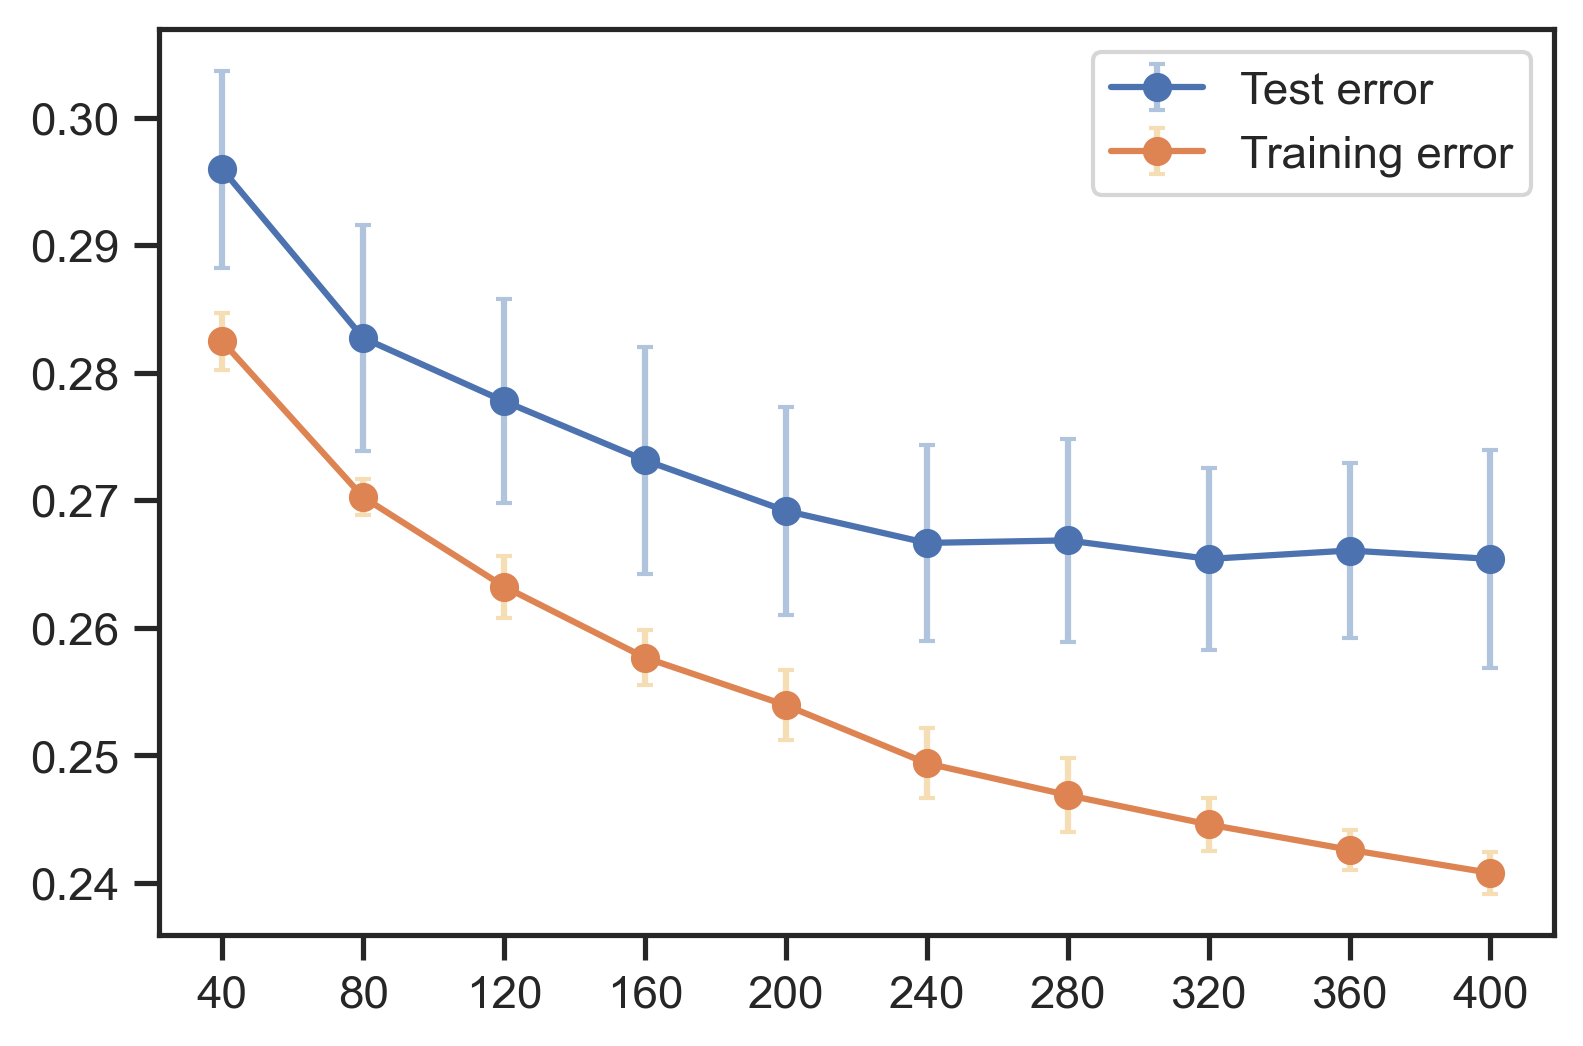

In [12]:
folds = folds_maker(dta['Cover_Type'])
test_cv_err, train_cv_err, test_err_band, train_err_band = CV(dta.iloc[:,:54],dta['Cover_Type'], folds)

#Plot the results for test error estimates
plt.errorbar(list(range(40, 401, 40)), test_cv_err, yerr=test_err_band, 
             marker='o', ls='-', label='Test error',
             ecolor='lightsteelblue', capsize=2, capthick=1)

#Plot the results for training error estimates
plt.errorbar(list(range(40, 401, 40)), train_cv_err, yerr=train_err_band, 
             marker='o', ls='-', label='Training error',
             ecolor='wheat', capsize=2, capthick=1)

plt.legend()
plt.xticks(range(40, 401, 40))
plt.show()

In [13]:
tab = pd.DataFrame({'Test error CV estimate' : pd.Series(test_cv_err).apply("{:.2%}".format), 
                    'Training error CV estimate' : pd.Series(train_cv_err).apply("{:.2%}".format)})

tab.index = range(40, 401, 40)
tab.index.name = 'Nr of AdaBoost rounds'
tab

,Test error CV estimate,Training error CV estimate
Nr of AdaBoost rounds,,
40,29.60%,28.25%
80,28.27%,27.03%
120,27.78%,26.32%
160,27.31%,25.77%
200,26.92%,25.39%
240,26.67%,24.94%
280,26.69%,24.69%
320,26.54%,24.46%
360,26.61%,24.26%


As one might expect, the training error is always lower than its test counterpart. Morever, while the training error keeps decreasing (even though at a diminishing rate), the test error stabilizes after 240 rounds. Since we do not risk overfitting, we decide to consider the model obtained with `T` = 300 rounds. 

Go to [Index](#Index)

# Training test procedure

We now adopt a training-test approach to explore more in depth the model's output. We split the original data set into a training set (80%) and a test set (20%), and then apply the `adaboost` algorithm on the training set with `T` = 300 rounds and test the resulting predictor on the test set. 

In [14]:
X_train, X_test, y_train, y_test = train_test_split(dta.iloc[:,:54], dta['Cover_Type'], test_size=0.2,
                                                    random_state=24, stratify=dta['Cover_Type'])

stumps, weights = adaboost(X_train, y_train, 300)
predictions, test_error = predict(X_test, y_test, stumps, weights)
train_error = predict(X_train, y_train, stumps, weights)[1]

print('Misclassification rate on the training set: ', round(train_error*100, 2), "%", sep='')
print('Misclassification rate on the test set: ', round(test_error*100, 2), "%", sep='')

Misclassification rate on the training set: 24.72%
Misclassification rate on the test set: 26.09%


The results we find are coherent with the cross-validation analysis. 

We now go more in depth with respect to the cross-validation analysis, for example highlighting, through the use of a confusion matrix, which classes were the hardest to classify.

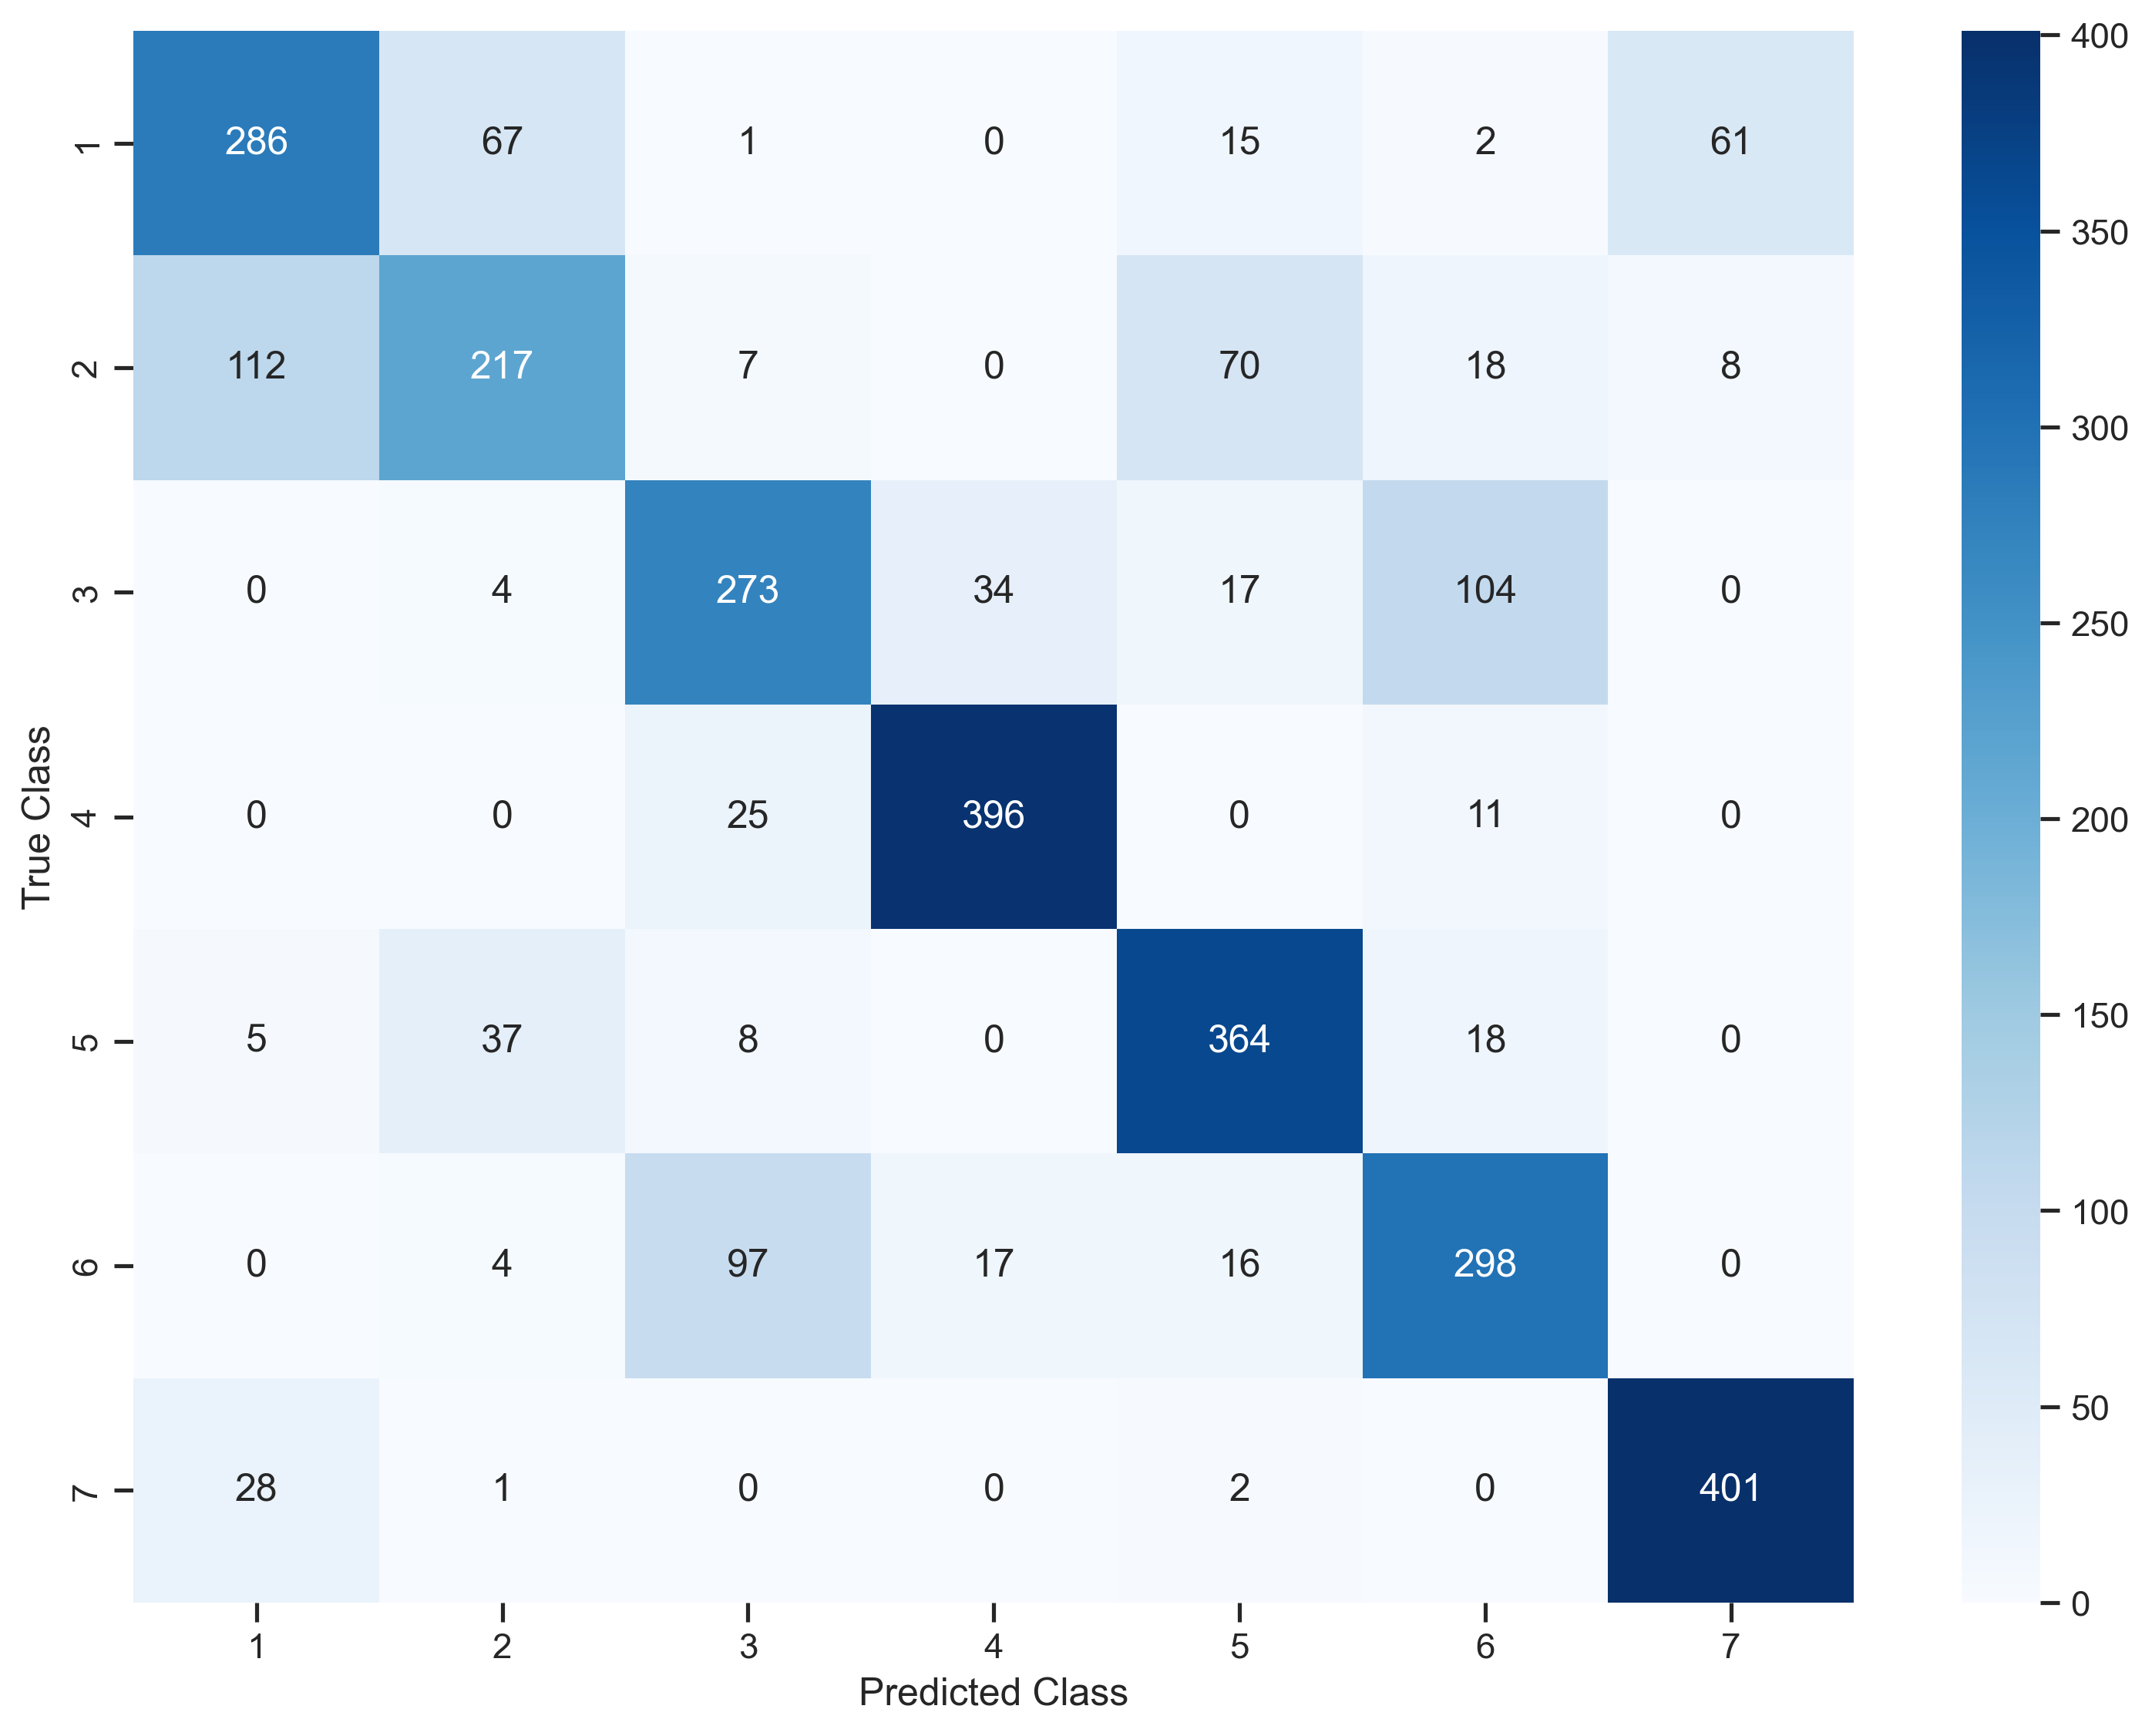

In [15]:
con_matrix = pd.DataFrame(confusion_matrix(y_test, predictions), index=range(1, 8), columns=range(1, 8))
fig, ax = plt.subplots(figsize = (12, 9))
heatmap = sns.heatmap(con_matrix, fmt='g', cmap='Blues', annot=True, ax=ax)
ax.set_ylabel("True Class")
ax.set_xlabel("Predicted Class")
plt.show()

Recall that we had 432 observations for each of the classes. Therefore, we can say that class 4, 5 and 7 were the ones for which the classification worked best, while the worst performances are related to class 2, where we manged to correctly identify just $217/432 \approx 50\%$ of the observations. In particular, we notice a frequent mismatch between: 

* Class 1 and 2, which in fact were similar in many aspects (see the [Exploratory data analysis](#Exploratory-data-analysis) section);
* Class 6 and 3, which were also similar, especially for what concerned the [quantitative predictors](#Quantitative-predictors).

Other relatively frequent misclassifications happen between:

* Class 1 and 7;
* Class 2 and 5.

We could conclude that the classes for which we observe the lower error are the ones characterised by some particular aspects which the algorithm correctly identified, while the classes for which we observe a larger error had many features in common with the other classes and so were harder to be distinguished.

## Variables importance

Finally, it could also be interesting to see which were the variables more used to perform the splits, i.e., the variables which characterized the most the observations. In fact, if a variable gets selected many times as a best split, it means it is a variable according to which it is easiest to distinguish among the different classes. The plot below shows the frequency by which each feature was selected as best split. 

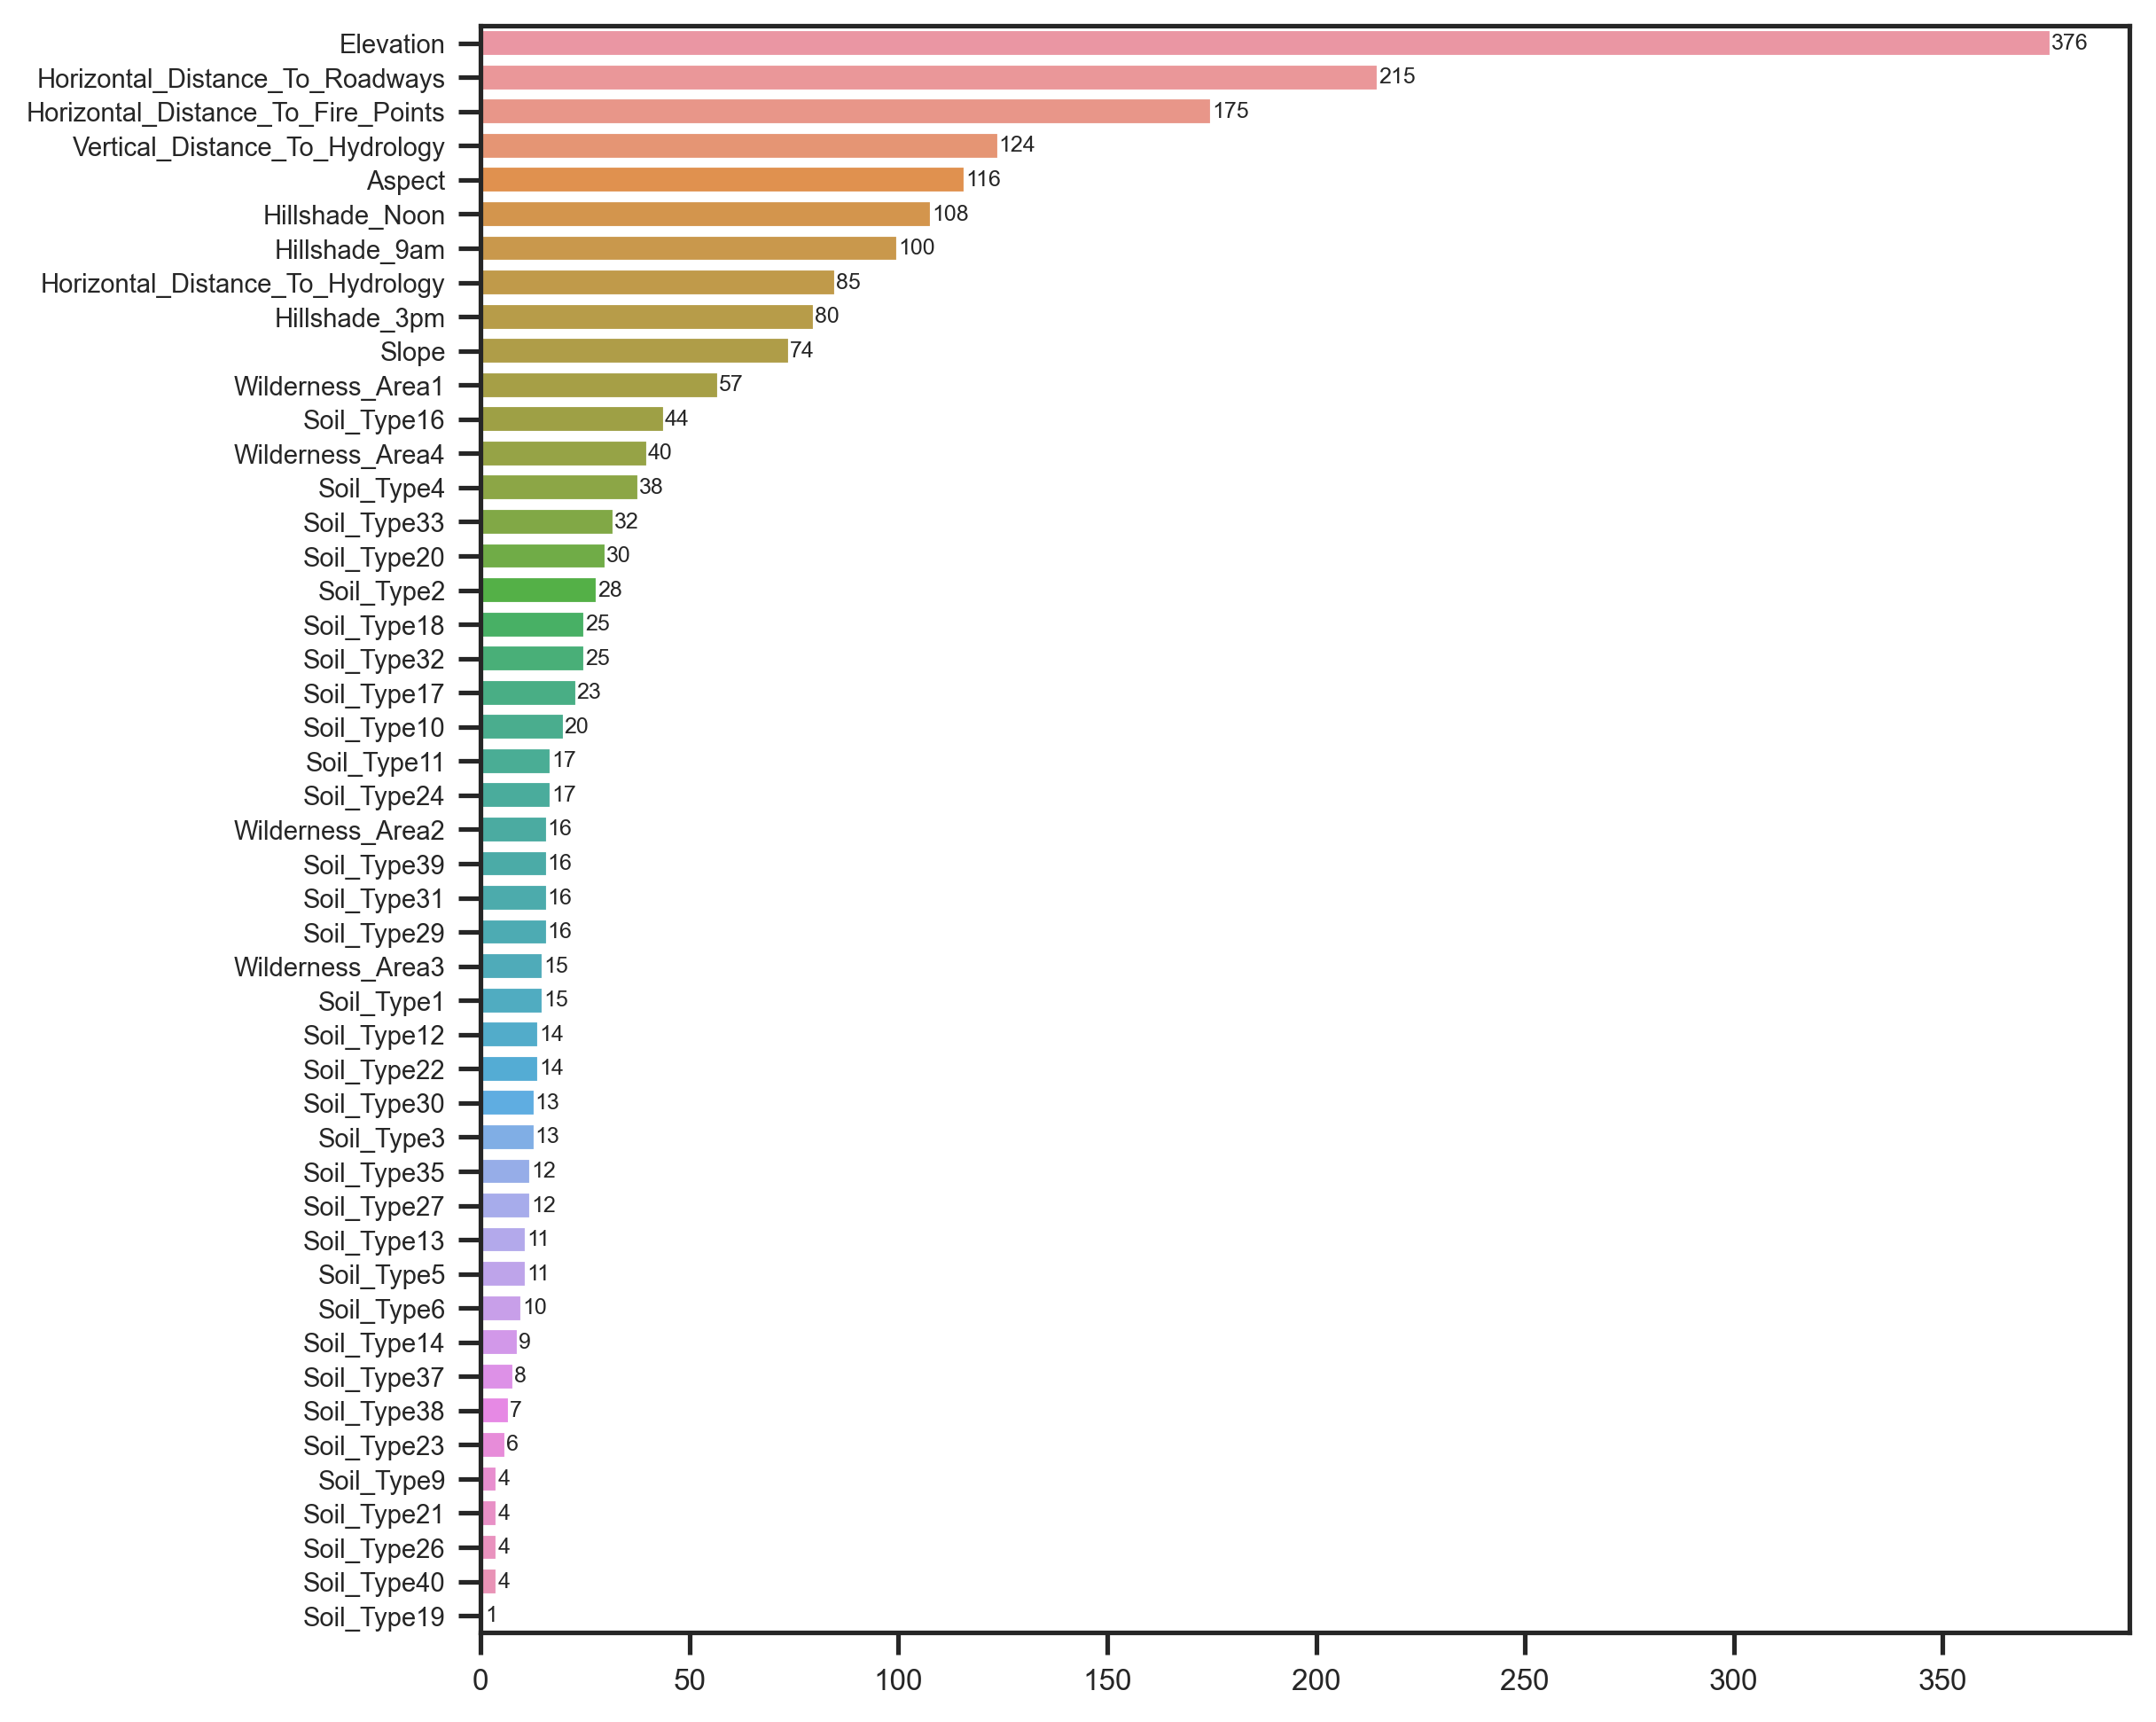

In [16]:
frequency, total, cumulative = pseudo_importance(stumps, weights)

fig, ax = plt.subplots(figsize=(8,8), dpi=300)
sns.barplot(y=frequency.index, x=frequency, ax=ax)
ax.tick_params(axis='y', labelsize=7)
ax.tick_params(axis='x', labelsize=8)
ax.bar_label(ax.containers[0], size=6)
plt.show()

Coherently with our discussion in the [Exploratory data analysis](#Exploratory-data-analysis) section, we find out `Elevation` is the most important variable, while other features are well far behind. In general, we also notice that numerical features tend to be selected more often than categorical predictors. \
However, to have a more precise idea of the goodness of the splits, we could consider the weight assigned to each split: we know that the higher is the weight, the better is the split. We therefore now plot the sum of the weights associated to each of the splits for which a certain feature was selected as best split. 

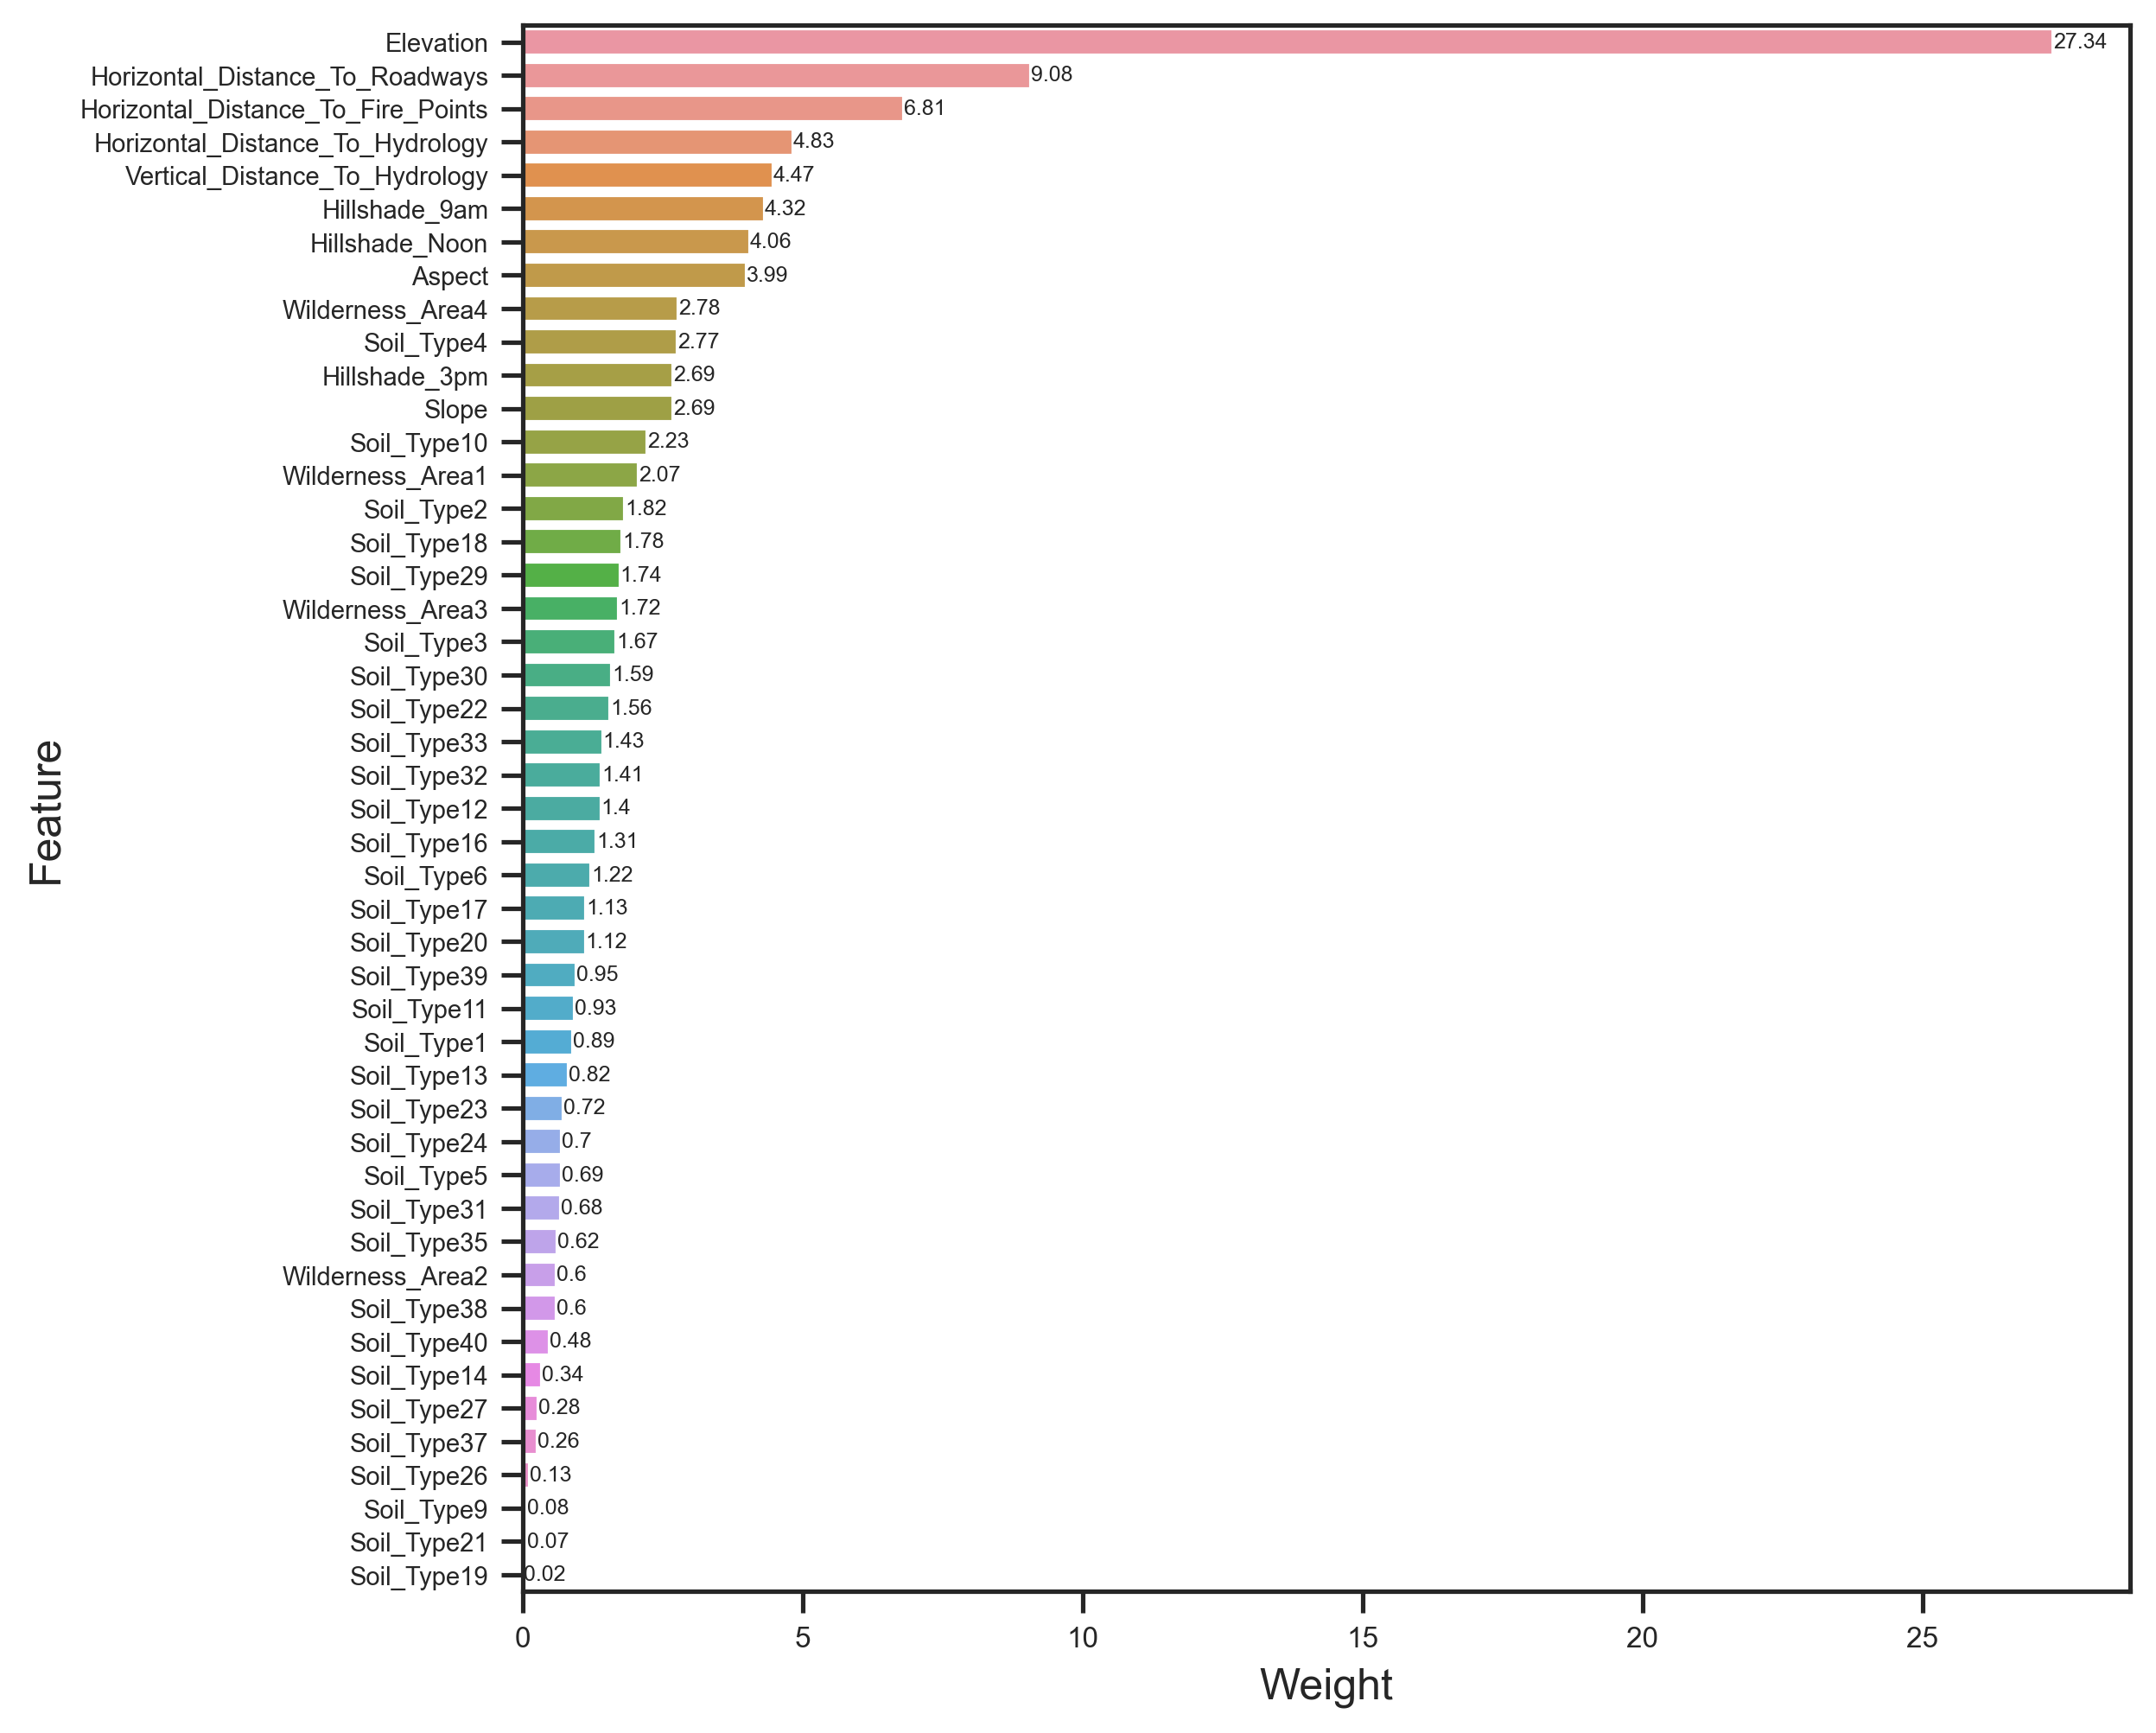

In [17]:
fig, ax = plt.subplots(figsize=(8,8), dpi=300)
sns.barplot(y=cumulative.index, x=np.round(cumulative,2), ax=ax)
ax.tick_params(axis='y', labelsize=7)
ax.tick_params(axis='x', labelsize=8)
ax.bar_label(ax.containers[0], size=6)
plt.show()

This plot is not very different from the previous one, as `Elevation` has still the leading role, together with the other numerical variables.

To conclude, we switch again our perspective and focus on the best splits for each of the classes, so that we can see which are the features more strongly characterizing each cover forest type. In particular, the table below shows the splits whose weight is larger than $0.5$. 

In [18]:
total[total['Weight'] > 0.5]

,Feature,Weight,Class,AdaBoost round,Theta,Greater is positive
0,Soil_Type22,0.951386,1,1,0.5,True
1,Elevation,0.698754,1,2,2916.0,True
300,Soil_Type12,0.947737,2,1,0.5,True
600,Soil_Type4,0.918524,3,1,0.5,True
601,Elevation,0.565129,3,2,2662.0,False
900,Soil_Type3,1.106283,4,1,0.5,True
901,Elevation,1.032857,4,2,2401.0,False
902,Horizontal_Distance_To_Hydrology,0.807088,4,3,30.0,False
1200,Soil_Type30,0.959116,5,1,0.5,True
1500,Soil_Type10,0.907453,6,1,0.5,True


First of all, we notice that all best performing splits are concentrated in the first AdaBoost rounds, and this is true for all the classes. In particular: 

* `Elevation` and `Soil_Type22` are the most important splits for class 1. Indeed, if we go back to the [Exploratory data analysis](#Exploratory-data-analysis) section, we notice class 1 observations tend to have a high elevation and constitute the greater majority in `Soil_Type22`. 
* `Soil_Type12` is the best split for class 2. Indeed, going back to the [qualitative predictors](#Qualitative-predictors) section, we notice 203 out of 227 observations in `Soil_Type12` are from class 2. 
* `Soil_Type4` and `Elevation` are the best splits for class 3. In fact, observations from this class constitute the greatest part of observations in `Soil_Type4` and class 3 shows a lower-than-average `Elevation`. 
* For what concerns class 4, the best split is performed according to `Soil_Type3` (almost all observations in this soil type are from class 4) and `Elevation` (class 4 has the lowest class-average elevation). Another particularly good split is performed according to `Horizontal_Distance_To_Hydrology`, and in fact if we go back to the [quantitative predictors](#Quantitative-predictors) section we notice class 4 has once again the lowest average for this variable, just like `Elevation`.
* Class 5 has just one split whose weight is above 0.5, and it is related to `Soil_Type30`: in fact, if we look at the related plot, we notice $480/725\approx 66\%$ of observations in this soil type are from class 5. 
* The best split for class 6 is related to `Soil_Type10`: indeed, $1101$ out of the $2160$ observations of class 6 are in `Soil_Type10`.
* Class 7 has four splits whose weight is above $0.5$, and in fact it is the class for which the classification worked better. As we had already noticed in the [qualitative predictors](#Qualitative-predictors) section, `Soil_Type39` played an important role for the correct classification of this class, together with `Elevation` (class 7 tends to have a particularly large elevation).

Go to [Index](#Index)

# Conclusion

In this paper, we implemented from scratch the AdaBoost algorithm, and then use it to perform multi-class classification on the [Cover-Type dataset](https://www.kaggle.com/c/forest-cover-type-prediction/data?select=train.csv). We then performed 5-fold cross-validation and found out that, after 240 AdaBoost rounds, there was basically no improvement in the test error rate. We therefore ran the algorithm on a training set with `T` = 300 AdaBoost rounds, and then test the obtained ensemble predictor on an independent test set. The test misclassification rate was coherent with our cross-validated findings, but the errors were not uniformly distributed across classes (we correctly classified $93\%$ of examples of class 7 but only $50\%$ of the ones from class 1). It turned out `Elevation` is overall the most important feature for predicting the classes, but each class has its own particular characteristics which makes it distinguishable from the others, and `Elevation` is not always part of them. 

Go to [Index](#Index)

# Appendix

This section just collects the code used to generate the figures that were displayed in the paper: 

- The weight function of the [AdaBoost](#AdaBoost) theoretical section
- Various figures from the [Exploratory data analysis](#Exploratory-data-analysis) section

In [ ]:
#Figure of weight function
eps = np.linspace(0.001, 0.999, 999)
w = 0.5*np.log((1-eps)/eps)

plt.plot(eps, w)
plt.xlabel("\u03B5")
plt.ylabel("w")
plt.title("Predictor's weight w as a function of its error \u03B5")
plt.axvline(0.5, ls='--', lw=0.7, color='gainsboro')
plt.axhline(0, ls='--', lw=0.7, color='gainsboro')
plt.show()

In [ ]:
#Labels distribution
count = np.array(dta['Cover_Type'].value_counts().sort_index())

sns.barplot(x=list(range(1, 8)), y=count, palette='Set1')
sns.despine()
plt.show()

In [ ]:
#Quantitative predictors
fig, axes = plt.subplots(5, 2, figsize=(8, 10), dpi=300)

r, feat = 0, 0

while feat < 10: 
    
    while r < 5:
        c = 0
        while c < 2: 
            sns.boxplot(data=dta, x='Cover_Type', y=dta.columns[feat], palette='Set1', ax=axes[r][c])
            axes[r][c].set_title(dta.columns[feat])
            axes[r][c].set_ylabel('')
            axes[r][c].set_xlabel('')
            feat += 1
            c +=1
            
        r += 1
        
    feat += 1

plt.tight_layout()    
plt.show()

In [ ]:
#Wilderness Area
fig, axes = plt.subplots(2, 2, figsize=(6, 6), dpi=300)
 
feat, r, txt = 10, 0, 3    

while feat < 14:
    
    while r < 2: 
        c = 0
        while c < 2: 
            val = dta.groupby('Cover_Type').sum()[dta.columns[feat]]
            
            sns.barplot(x=list(range(1, 8)), y=val, palette='Set1', ax=axes[r][c])
            axes[r][c].bar_label(axes[r][c].containers[0], size=6)
            axes[r][c].set_title(dta.columns[feat])
            axes[r][c].set_xlabel('')
            axes[r][c].set_ylabel('')
            axes[r][c].text(txt, max(val), s = 'Total trees: ' + str(sum(val)), fontsize=8)
            feat += 1
            c += 1
        
        r += 1
        txt = 0
    
    feat += 1

plt.tight_layout()
plt.show()

In [ ]:
#Soil type distribution
fig, ax = plt.subplots(figsize=(6,6), dpi=300)

count = pd.Series([dta[col].sum() for col in dta.columns[14:54]], index=dta.columns[14:54])
count.sort_values(ascending=False, inplace=True)

sns.barplot(y=count.index, x=count, ax=ax)
ax.tick_params(axis='y', labelsize=7)
ax.tick_params(axis='x', labelsize=8)
ax.bar_label(ax.containers[0], size=5)
plt.show()

In [ ]:
#Soil type across classes
fig, axes = plt.subplots(8, 5, figsize=(11, 15), dpi=300)
 
feat, r = 14, 0    

while feat < 54:
    
    while r < 8: 
        c = 0
        while c < 5: 
            val = dta.groupby('Cover_Type').sum()[dta.columns[feat]]
            
            sns.barplot(x=list(range(1, 8)), y=val, palette='Set1', ax=axes[r][c])
            axes[r][c].bar_label(axes[r][c].containers[0], size=6)
            axes[r][c].set_title(dta.columns[feat])
            axes[r][c].set_xlabel('')
            axes[r][c].set_ylabel('')
            feat += 1
            c += 1
        
        r += 1
    
    feat += 1

plt.tight_layout()
plt.show()

Go to [Index](#Index)